In [1]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import cvxpy as cp
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron
from statsmodels.tsa.vector_ar import vecm
import copulas
import var
from copulas.univariate import Univariate
from var import VaR, load_data
import pyfolio as pf
from statsmodels.regression.rolling import RollingOLS
import copulae
from copulas.multivariate import GaussianMultivariate
from statsmodels.distributions.copula.api import StudentTCopula
from copulas.bivariate import Gumbel
import copulas.visualization
import arch
import scipy as sp
from numpy import average, exp
from copulas.univariate import Univariate
from scipy.stats import t

In [2]:
act_put = pd.read_excel("putNVDA.xlsx")[["Strike", "Implied Volatility", "Last Price"]]


In [3]:
act_put = act_put[(act_put["Implied Volatility"]>0)&(act_put["Last Price"]>5)].dropna().reset_index()
act_put

,index,Strike,Implied Volatility,Last Price
0,40,325,0.4296,5.10
1,41,330,0.4259,5.50
2,42,335,0.4237,6.49
3,43,340,0.4207,7.00
4,44,345,0.4179,7.31
...,...,...,...,...
79,124,780,0.3486,284.90
80,125,785,1.1505,349.21
81,126,790,1.1564,354.79
82,127,795,1.1623,359.81


In [4]:
S0 = 482
T = 0.48 # maturity in years
r = 0.044 # risk-free rate
d = 0.00033 # dividend yield
n_simulation = 80000 # number of simulations 
n_steps = 122
dt = T/n_steps

In [5]:
simulated_put = []
for k in range(len(act_put)):
    K = act_put["Strike"][k]
    sigma =  act_put["Implied Volatility"][k]
    print(K, sigma)
    put_ = sp.zeros([n_simulation],dtype=float)
    for j in range(0, n_simulation):
        ST=S0
        total=0
        for i in range(0,int(n_steps)):
            e=np.random.standard_t(df=4)
            ST=ST*np.exp((r-d-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*e)
            total+=ST
        price_average=total/n_steps
        put_[j]=max(price_average-K,0)*exp(-r*T)
    put_price=average(put_)
    simulated_put.append(put_price)
    print('put price = ', round(put_price,2) )

325 0.4296
put price =  171.74
330 0.4259
put price =  165.99
335 0.4237
put price =  161.93
340 0.4207
put price =  156.83
345 0.4179
put price =  151.97
350 0.4153
put price =  145.7
355 0.4128
put price =  142.63
360 0.4103
put price =  137.53
365 0.4079
put price =  133.34
370 0.4055
put price =  128.69
375 0.4031
put price =  124.11
380 0.4006
put price =  119.34
385 0.3993
put price =  115.3
390 0.3967
put price =  111.04
395 0.3935
put price =  106.33
400 0.3928
put price =  102.53
405 0.3909
put price =  98.35
410 0.3884
put price =  94.22
415 0.3871
put price =  91.15
420 0.3848
put price =  86.87
425 0.3831
put price =  82.91
430 0.3817
put price =  79.08
435 0.3797
put price =  75.23
440 0.3779
put price =  71.88
445 0.3758
put price =  68.54
450 0.374
put price =  65.46
455 0.372
put price =  62.02
460 0.3702
put price =  58.73
465 0.3685
put price =  55.81
470 0.367
put price =  52.74
475 0.3638
put price =  49.23
480 0.3626
put price =  47.27
485 0.3605
put price =  43.91

In [7]:
simu_put_df = pd.DataFrame(simulated_put)
simu_put_df.columns = ["Simulated put Price"]
simu_put_df.to_excel("simulated_put_price.xlsx")

In [8]:
# ran in different notebook simultaneously to reduce total running time, so the result is not shown

act_call = pd.read_excel("callNVDA.xlsx")[["Strike", "Implied Volatility", "Last Price"]]
act_call = act_call[(act_call["Implied Volatility"]>0)&(act_call["Last Price"]>5)].dropna().reset_index()
"""
simulated_call = []
for k in range(len(act_call)):
    K = act_call["Strike"][k]
    sigma =  act_call["Implied Volatility"][k]
    print(K, sigma)
    call_ = sp.zeros([n_simulation],dtype=float)
    for j in range(0, n_simulation):
        ST=S0
        total=0
        for i in range(0,int(n_steps)):
            e=np.random.standard_t(df=4)
            ST=ST*np.exp((r-d-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*e)
            total+=ST
        price_average=total/n_steps
        call_[j]=max(price_average-K,0)*exp(-r*T)
    call_price=average(call_)
    simulated_call.append(call_price)
    print('call price = ', round(call_price,2) )

simu_call_df = pd.DataFrame(simulated_call)
simu_call_df.columns = ["Simulated Call Price"]
simu_call_df.to_excel("simulated_call_price.xlsx")"""

'\nsimulated_call = []\nfor k in range(len(act_call)):\n    K = act_call["Strike"][k]\n    sigma =  act_call["Implied Volatility"][k]\n    print(K, sigma)\n    call_ = sp.zeros([n_simulation],dtype=float)\n    for j in range(0, n_simulation):\n        ST=S0\n        total=0\n        for i in range(0,int(n_steps)):\n            e=np.random.standard_t(df=4)\n            ST=ST*np.exp((r-d-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*e)\n            total+=ST\n        price_average=total/n_steps\n        call_[j]=max(price_average-K,0)*exp(-r*T)\n    call_price=average(call_)\n    simulated_call.append(call_price)\n    print(\'call price = \', round(call_price,2) )\n\nsimu_call_df = pd.DataFrame(simulated_call)\nsimu_call_df.columns = ["Simulated Call Price"]\nsimu_call_df.to_excel("simulated_call_price.xlsx")'

In [15]:
simu_call_df = pd.read_excel("simulated_call_price.xlsx")

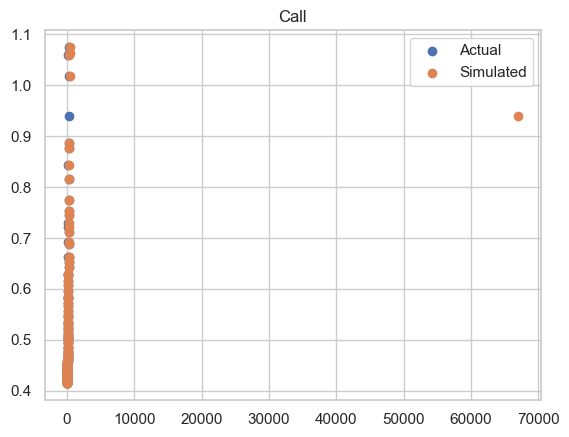

In [26]:
plt.scatter(act_call["Last Price"], act_call["Implied Volatility"], label="Actual")
plt.scatter(simu_call_df["Simulated Call Price"], act_call["Implied Volatility"], label="Simulated")
plt.title("Call")
plt.legend()
plt.show()

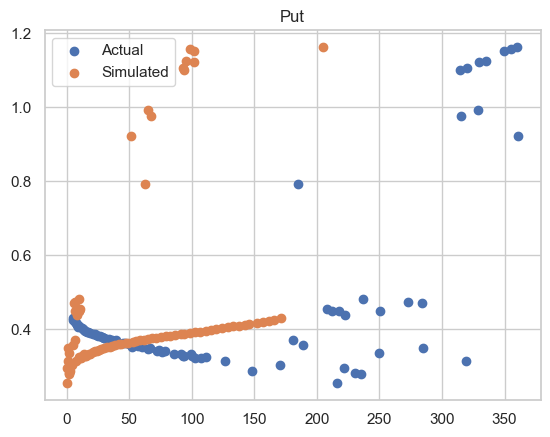

In [25]:
plt.scatter(act_put["Last Price"], act_put["Implied Volatility"], label="Actual")
plt.scatter(simu_put_df["Simulated put Price"], act_put["Implied Volatility"], label="Simulated")
plt.title("Put")
plt.legend()
plt.show()

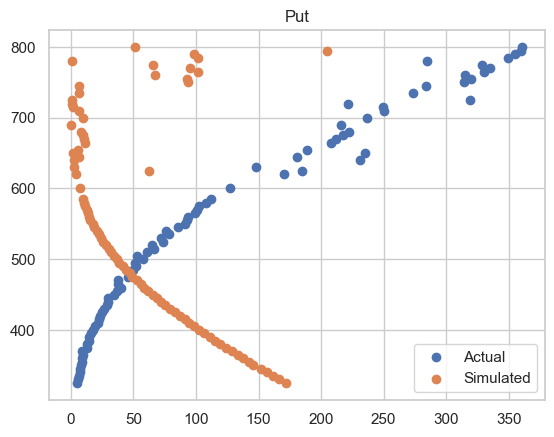

In [37]:
plt.scatter(act_put["Last Price"], act_put["Strike"], label="Actual")
plt.scatter(simu_put_df["Simulated put Price"], act_put["Strike"], label="Simulated")
plt.title("Put")
plt.legend()
plt.show()

In [18]:
np.corrcoef(act_call["Last Price"], simu_call_df["Simulated Call Price"])


array([[1.        , 0.24453883],
       [0.24453883, 1.        ]])

In [13]:
np.corrcoef(act_put["Last Price"], simu_put_df["Simulated put Price"])


array([[ 1.        , -0.31378666],
       [-0.31378666,  1.        ]])

In [21]:
abs((act_call["Last Price"]-simu_call_df["Simulated Call Price"])).mean()/len(act_call["Last Price"])


5.155418044204175

In [22]:
abs((act_put["Last Price"]-simu_put_df["Simulated put Price"])).mean()/len(act_put["Last Price"])

1.5120180154236567

Text(0.5, 1.0, 'put')

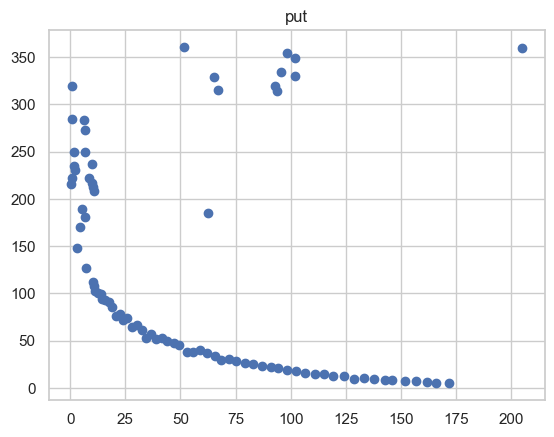

In [27]:
plt.scatter(simu_put_df["Simulated put Price"], act_put["Last Price"])
plt.title("put")

Text(0.5, 1.0, 'call')

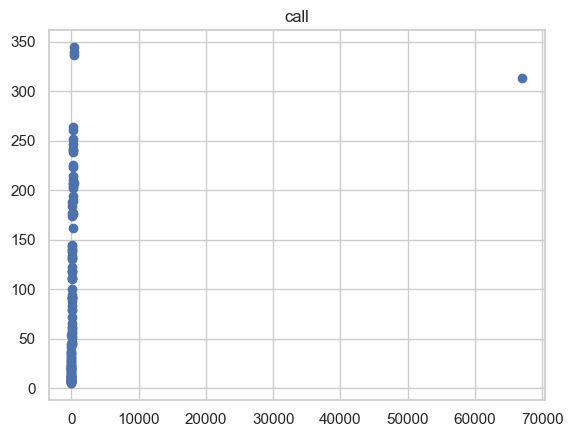

In [28]:
plt.scatter(simu_call_df["Simulated Call Price"], act_call["Last Price"])
plt.title("call")


Text(0.5, 1.0, 'call')

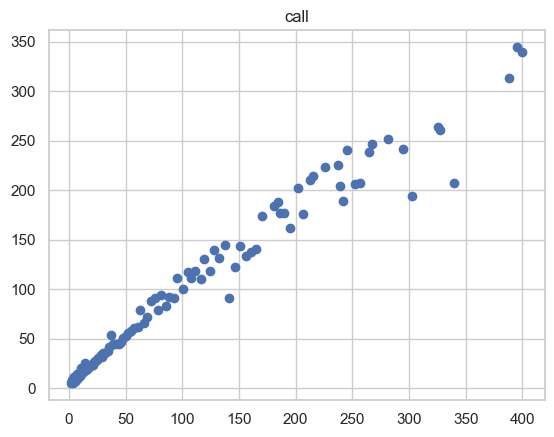

In [32]:
plt.scatter(simu_call_df[simu_call_df["Simulated Call Price"].index!=111]["Simulated Call Price"], act_call[act_call["Last Price"].index!=112]["Last Price"])
plt.title("call")

In [33]:
np.corrcoef(simu_call_df[simu_call_df["Simulated Call Price"].index!=111]["Simulated Call Price"], act_call[act_call["Last Price"].index!=112]["Last Price"])


array([[1.        , 0.98442359],
       [0.98442359, 1.        ]])

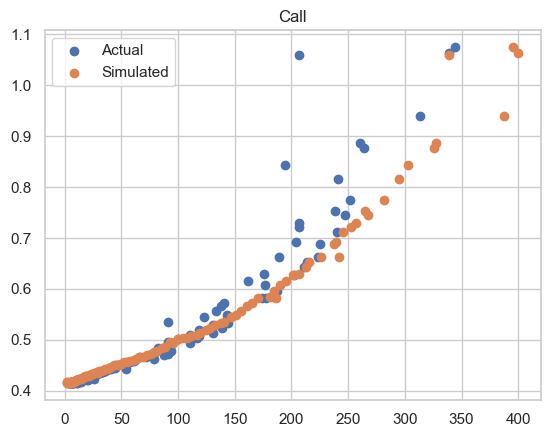

In [34]:
plt.scatter(act_call[act_call["Last Price"].index!=112]["Last Price"], act_call[act_call["Last Price"].index!=112]["Implied Volatility"], label="Actual")
plt.scatter(simu_call_df[simu_call_df["Simulated Call Price"].index!=111]["Simulated Call Price"], act_call[act_call["Last Price"].index!=112]["Implied Volatility"], label="Simulated")
plt.title("Call")
plt.legend()
plt.show()

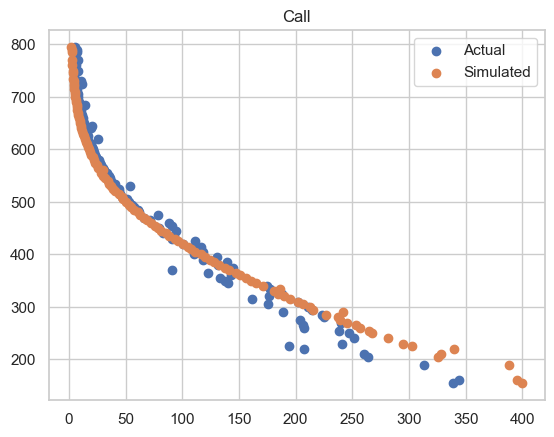

In [38]:
plt.scatter(act_call[act_call["Last Price"].index!=112]["Last Price"], act_call[act_call["Last Price"].index!=112]["Strike"], label="Actual")
plt.scatter(simu_call_df[simu_call_df["Simulated Call Price"].index!=111]["Simulated Call Price"], act_call[act_call["Last Price"].index!=112]["Strike"], label="Simulated")
plt.title("Call")
plt.legend()
plt.show()

In [36]:
abs((simu_call_df[simu_call_df["Simulated Call Price"].index!=111]["Simulated Call Price"] - act_call[act_call["Last Price"].index!=112]["Last Price"])).mean()/(len(act_call["Last Price"])-1)


0.11281959697318004